In [ ]:
import numpy as np
import matplotlib.pyplot as plt

**Лабораторная 5.1**

In [ ]:
class RBF:
    def __init__(self, R = 1) -> None:
        self.R = 1
        self.A = 1/(2 * self.R * self.R)
    
    def fun_act(self, x, r, c):
        return np.exp(-np.square(x - c)/np.square(r))

    def fun_h(self, x,r,c):
        return np.exp(-r*np.abs(x - c))

    def fun_H(self, t_x, t_c, r):
        H = np.zeros((len(t_x), len(t_c)))
        for i in range(len(t_x)):
            for j in range(len(t_c)):
                H[i][j] = self.fun_h(t_x[i], r, t_c[j])
        return H

    def fun_RBN(self, x, t_c, a, w):
        h = np.zeros((len(t_c)))
        for i in range(len(t_c)):
            h[i] = self.fun_h(x, a, t_c[i])
        return np.dot(h,w)

    def fit(self, x, y, c):
        H = self.fun_H(x, c, self.A)
        H_ = np.dot(np.linalg.inv(np.dot(H.transpose(), H)), H.transpose())
        W = np.dot(H_, y)
        self.W = W

    def predict(self, data, c):
        pred_y = np.zeros((len(data)))
        for i in range(len(data)):
            pred_y[i] = self.fun_RBN(data[i], c, self.A, self.W)
        return pred_y

In [ ]:
def sigmoid(x):
    #Сигмоидная функция активации: f(x) = 1 / (1 + e^(-x))
    return x / (1 + np.abs(x))
    #return 1 if x > 0 else 0

def dersigmoid(s):
  return 1 / (1 + np.abs(s))**2

def Hebb(weight, ny, x0, y, e):
    return weight - ny * x0 * (y - e)

In [ ]:
class Neuron:
    def __init__(self, weights, bias =1, biasWigth = 1, knowingRatio = 0.9):
        self.Weights = weights
        self.DeltaWeights = np.zeros(len(weights))
        self.Bias = bias
        self.KnowingRatio = knowingRatio
        self.Beta = 0
        self.dW = 0
        self.dB = 0
        self.BiasWigth = biasWigth
    
    def feedforward(self, inputs):
        self.LastInput = inputs
        total = np.dot(self.Weights, inputs) + self.Bias * self.BiasWigth
        self.LastRezult = total
        return sigmoid(total)
    
    def WeightCorrection(self, lam):
      self.dW = self.KnowingRatio*self.dW + (1 - self.KnowingRatio) * np.square(self.Beta) 
      self.dB = self.KnowingRatio*self.dB + (1 - self.KnowingRatio) * np.square(self.Beta)
      
      self.Weights = self.Weights - np.dot(lam * self.Beta/(np.sqrt(self.dW) + 0.0001), self.LastInput)
      self.BiasWigth = self.BiasWigth - lam * self.Beta/(np.sqrt(self.dB) + 0.0001)

In [ ]:
class HebbNetworkGradient:
    def __init__(self, neuronsCountArray,biasWeights = [], Weights = [],
                eps = 0.1, lam = 0.1, epochs = 20000, neuroneKnowingRatio = 0.9,
                 drawInfo = True, drawInfoEpochs = 1000):
        '''
        neuronsCountArray example [25, 14, 7, 3, 1] where each number mean
         a count of neurons in the layer
        ''' 
        self.IsDrawInfo = drawInfo
        self.DrawInfoEpochs = drawInfoEpochs

        self.Eps = eps
        self.T = 0
        self.Epochs = epochs
        self.Lam = lam
        self.BestWeights = []
        self.BestBiasWeights = []
        self.BestL = 10000000000
        self.L = []
        self.Neurons = {}
        for i in range(1, len(neuronsCountArray)):
          self.Neurons[i] = []
          if(len(Weights) == 0):
            for j in range(neuronsCountArray[i]):
              self.Neurons[i].append(Neuron(np.random.randint(-10,10,neuronsCountArray[i-1]), 1, knowingRatio=neuroneKnowingRatio)) 
          else:
            print(i)
            for j in range(len(Weights[i-1])):
              self.Neurons[i].append(Neuron(Weights[i-1][j], 1, biasWeights[i-1][j], knowingRatio=neuroneKnowingRatio))
    
    def fit(self, X, y):
        self.T = 1
        self.CalculateLoss(X,y)
        while self.L[len(self.L)-1] > self.Eps and self.T < self.Epochs:
            print(f"epoch: {self.T}")
            print(f"L = {self.L[len(self.L) - 1]}")
            n_rule = np.random.randint(len(X))
            #for n_rule in range(len(X)):
            e = self.feedforward(X[n_rule])
            if any(np.abs(self.lossFunction(y[n_rule],e))) > self.Eps:
              #if np.argmax(y[n_rule]) != e.index(max(e)):
                  self.WeightCorrection(y[n_rule])
                  self.CalculateLoss(X,y)
                  self.T+=1
        print("network was learned for",self.T,"generations")
    
    def predict(self, data):
        y = []
        for i in data:
          y.append(self.feedforward(i))
        return y
        
    def feedforward(self, inputs):
        y = [neuron.feedforward(inputs) for neuron in self.Neurons[1]]
        for i in self.Neurons:
          if i == 1:
            continue
          else:
            y = [neuron.feedforward(y) for neuron in self.Neurons[i]]
        
        return y

    def lossFunction(self, e, y):
      return np.abs((e - y)/e)

    def CalculateLoss(self, x,y):
      loss = 0
      for j in range(len(x)):
        e = self.feedforward(x[j])
        loss += np.average(self.lossFunction(e, y[j]))
      
      self.L.append(loss/len(y))
      
      if(self.L[len(self.L)-1] < self.BestL):
        self.BestL = self.L[len(self.L)-1]
        print("New best L:",self.BestL)
        weigths = []
        for i in self.Neurons:
          weigths.append([])
          for j in self.Neurons[i]:
            weigths[i-1].append(j.Weights)
        self.BestWeights = weigths

        weigths = []
        for i in self.Neurons:
          weigths.append([])
          for j in self.Neurons[i]:
            weigths[i-1].append(j.BiasWigth)
        self.BestBiasWeights = weigths
      
      
      if self.IsDrawInfo and self.T % self.DrawInfoEpochs == 0 and self.T != 0:
        ratio = self.DrawInfoEpochs
        print("T",self.T,"Loss",self.L[len(self.L)-1], "BestLoss", self.BestL)
        plt.plot(range(self.T-ratio,self.T), self.L[(self.T-ratio):self.T])
        plt.show()
      
      return self.L[len(self.L)-1]

    def WeightCorrection(self,e):
      for i in range(len(self.Neurons[len(self.Neurons)])):
        neurone = self.Neurons[len(self.Neurons)][i]
        y = sigmoid(neurone.LastRezult)
        beta = (y - e[i]) * dersigmoid(neurone.LastRezult)
        neurone.Beta = beta
        neurone.WeightCorrection(self.Lam)
        beta1 = beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, len(self.Neurons)-1)

      self.BackLayerPropagation(len(self.Neurons)-1)

      self.Optimization()

    
    def BackLayerPropagation(self, layerIndex):
      if layerIndex == 0:
        return
      #Для всех слоёв не считая начального
      for neurone in self.Neurons[layerIndex]:
        neurone.WeightCorrection(self.Lam)
        beta1 = neurone.Beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, layerIndex-1)
        
      
      self.BackLayerPropagation(layerIndex-1) 

    def Optimization(self):
      for layerIndex in range(1, len(self.Neurons)+1):
        for neurone in self.Neurons[layerIndex]: 
          neurone.Beta = 0


    def AddBetaInPreviousLayer(self, beta, layerIndex):
      if layerIndex == 0:
        return
      for i in range(len(self.Neurons[layerIndex])):
        self.Neurons[layerIndex][i].Beta += beta[i]

In [ ]:
def function(x):
  return np.power(x, 3) * np.cos(x)

In [ ]:
x_min = -50
x_max = 80
x = np.arange(x_min, x_max, 0.5)
x = x.reshape(-1,1)
y = function(x)
y = y.reshape(-1,1)
y = y/np.max(y)
n = 5
c = np.arange(x_min, x_max, (x_max-x_min)/n)
c = c.reshape(-1,1)

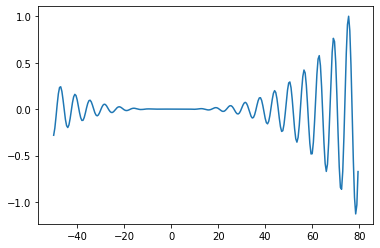

In [ ]:
plt.plot(x, y)

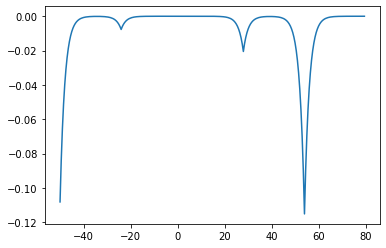

In [ ]:
rbf = RBF()
rbf.fit(x, y, c)
y_rbf = rbf.predict(x, c)
plt.plot(x, y_rbf)

In [ ]:
perceptron1layer = HebbNetworkGradient([1,7,1], neuroneKnowingRatio=0.3, eps = 0.1, lam=0.001, drawInfo=False)
perceptron1layer.fit(x,y)

New best L: 1.0097943941006051
epoch: 1
L = 1.0097943941006051
epoch: 2
L = 1.0097950720579316
epoch: 3
L = 1.009795649120775
epoch: 4
L = 1.00979654861753
epoch: 5
L = 1.0097973412894914
epoch: 6
L = 1.0097978513177719
epoch: 7
L = 1.0097984508202902
epoch: 8
L = 1.0097991146010248
epoch: 9
L = 1.0097996657494885
epoch: 10
L = 1.0098003860556526
epoch: 11
L = 1.0098011647926106
epoch: 12
L = 1.0098019221174572
epoch: 13
L = 1.0098024350873327
epoch: 14
L = 1.0098027646082064
epoch: 15
L = 1.0098032692873673
epoch: 16
L = 1.0098037998403893
epoch: 17
L = 1.0098044209642767
epoch: 18
L = 1.0098051322089725
epoch: 19
L = 1.009805805630189
epoch: 20
L = 1.0098063088080125
epoch: 21
L = 1.0098068367612605
epoch: 22
L = 1.009807366785312
epoch: 23
L = 1.0098079198762748
epoch: 24
L = 1.0098080234750726
epoch: 25
L = 1.0098087475362119
epoch: 26
L = 1.0098093628237594
epoch: 27
L = 1.0098100422428207
epoch: 28
L = 1.0098107354824606
epoch: 29
L = 1.0098115053211711
epoch: 30
L = 1.0098121366

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


Выходные данные были обрезаны до нескольких последних строк (5000).
L = 1.0240266953057482
epoch: 17501
L = 1.0981851190922471
epoch: 17502
L = 1.0029989375004358
epoch: 17503
L = 1.0040033955495078
epoch: 17504
L = 1.0086850637503717
epoch: 17505
L = 1.0156887883157208
epoch: 17506
L = 1.0111528293646255
epoch: 17507
L = 1.1233206175217871
epoch: 17508
L = 1.0142942440347407
epoch: 17509
L = 1.0161654937786462
epoch: 17510
L = 1.0426113864050686
epoch: 17511
L = 1.0135190268742735
epoch: 17512
L = 1.0141200357477929
epoch: 17513
L = 1.0140011093873542
epoch: 17514
L = 1.0150516980317388
epoch: 17515
L = 1.014568169585915
epoch: 17516
L = 1.016445900891713
epoch: 17517
L = 9.71997381391573
epoch: 17518
L = 1.015652924132975
epoch: 17519
L = 1.0163872153273916
epoch: 17520
L = 1.0298853854127
epoch: 17521
L = 1.0158739880941317
epoch: 17522
L = 1.0147659546194159
epoch: 17523
L = 1.2634306200407175
epoch: 17524
L = 1.0044654318092334
epoch: 17525
L = 1.0058735893790225
epoch: 17526
L = 

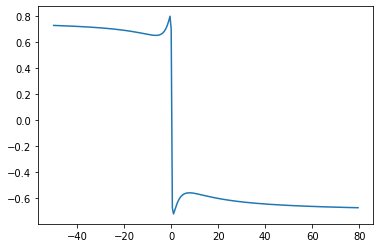

In [ ]:
y_perc1 = perceptron1layer.predict(x)
plt.plot(x, y_perc1)

In [ ]:
perceptron2layer = HebbNetworkGradient([1,7,7,1], neuroneKnowingRatio=0.3, eps = 0.1, lam=0.001, drawInfo=False)
perceptron2layer.fit(x,y)

New best L: 0.9932280150814448
epoch: 1
L = 0.9932280150814448
epoch: 2
L = 0.9932291293691724
epoch: 3
L = 0.9932299676600921
epoch: 4
L = 0.993234430754221
epoch: 5
L = 0.9932350927362384
epoch: 6
L = 0.9932364587427341
epoch: 7
L = 0.9932426823828415
epoch: 8
L = 0.9932453407272863
epoch: 9
L = 0.9932458835827447
epoch: 10
L = 0.993246577939806
epoch: 11
L = 0.9932505562669858
epoch: 12
L = 0.9932533708326174
epoch: 13
L = 0.9932541308076739
epoch: 14
L = 0.9932570443325562
epoch: 15
L = 0.9932600617929438
epoch: 16
L = 0.9932639706599772
epoch: 17
L = 0.993264590539403
epoch: 18
L = 0.9932655852084935
epoch: 19
L = 0.9932725251012318
epoch: 20
L = 0.9932734718104557
epoch: 21
L = 0.9932770493112931
epoch: 22
L = 0.9932778502658433
epoch: 23
L = 0.9932862741215934
epoch: 24
L = 0.9932924474603035
epoch: 25
L = 0.9932934875942874
epoch: 26
L = 0.9932948024732757
epoch: 27
L = 0.9932964999651013
epoch: 28
L = 0.9933037116961069
epoch: 29
L = 0.9933060662156165
epoch: 30
L = 0.99330608

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


Выходные данные были обрезаны до нескольких последних строк (5000).
L = 1.0143065749834266
epoch: 17501
L = 1.0146723409221576
epoch: 17502
L = 1.015620448298142
epoch: 17503
L = 1.0438298315639618
epoch: 17504
L = 1.0295396091319866
epoch: 17505
L = 1.7308602142665528
epoch: 17506
L = 7.551171908250808
epoch: 17507
L = 1.0162829659241834
epoch: 17508
L = 10.657462190003406
epoch: 17509
L = 8.077480657828318
epoch: 17510
L = 5.966210144976496
epoch: 17511
L = 1.2638593121881487
epoch: 17512
L = 1.3152412527450912
epoch: 17513
L = 1.2667248942264635
epoch: 17514
L = 1.9958479341865445
epoch: 17515
L = 14.006402278627597
epoch: 17516
L = 1.7388867747925518
epoch: 17517
L = 1.5677077563474964
epoch: 17518
L = 1.1839040953658415
epoch: 17519
L = 1.2056953578100056
epoch: 17520
L = 1.3698036101842423
epoch: 17521
L = 2.0004350233428267
epoch: 17522
L = 1.9040446414907892
epoch: 17523
L = 1.2936485167323468
epoch: 17524
L = 22.74273812395458
epoch: 17525
L = 7.28120283105003
epoch: 17526
L =

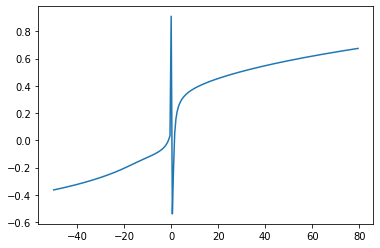

In [ ]:
y_perc2 = perceptron2layer.predict(x)

plt.plot(x, y_perc2)

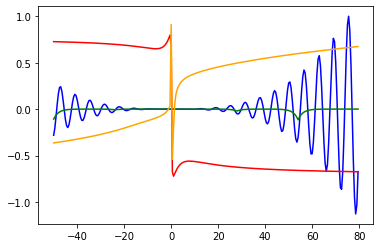

In [ ]:
plt.plot(x, y, color='blue')
plt.plot(x, y_rbf, color='green')
plt.plot(x, y_perc1, color='red')
plt.plot(x, y_perc2, color='orange')

**Лабораторная 5.2**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive 

In [ ]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 2_5472053557924468223.gdoc
 Business_Result_2ed_Pre_Intermediate_Students_Book_www.frenglish.ru.pdf
 CardBlue.svg
'Colab Notebooks'
 man.png
 neuron.xlsx
 Python.gdoc
 sp63555.exe
 titanic.csv
 winequality-red.csv
 woman.png
'Баги доработки.gdoc'
'Вопросы по JS.gdoc'
'для максима.mp3'
 Др.m4a
'Копия Random Dice Deck Database (1).gsheet'
'Копия Random Dice Deck Database (2).gsheet'
'Копия Random Dice Deck Database.gsheet'
'Копия Таблица момона с расчетами урона 3.xlsx'
 Лабы.gsheet
'Новый документ (1).gdoc'
'Новый документ (2).gdoc'
'Новый документ (3).gdoc'
'Новый документ (4).gdoc'
'Новый документ.gdoc'
 питон.rar
'Секс фантазии .gdoc'
'Сущности курсовая работа.gdoc'
 Табличка.gsheet
'Тест для вступления в Радиоцентр Лос-Сантос..gform'
'Фото Самсунг '


In [ ]:
exel_data = pd.read_excel("/content/drive/My Drive/neuron.xlsx")

In [ ]:
df = exel_data.drop(labels=[0], axis = 0)

In [ ]:
course_df = df[['Дата', 'Температура']]

In [ ]:
course_df.head(50)

,Дата,Температура
1,2022-11-14,8
2,2022-11-15,-7
3,2022-11-16,11
4,2022-11-17,-3
5,2022-11-18,20
6,2022-11-19,-4
7,2022-11-20,-9
8,2022-11-21,-2
9,2022-11-22,-3
10,2022-11-23,-7


In [ ]:
y = np.array(course_df['Температура'])
x = np.arange(y.size)

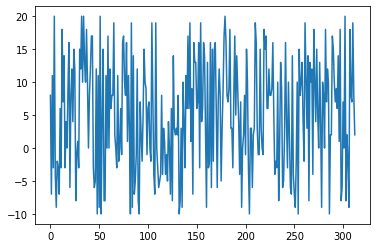

In [ ]:
y = y.reshape((-1,1))
x = x.reshape((-1,1))
plt.plot(x, y)

In [ ]:
def slidingWindow(y, windowSize, predCount):
    y_rez = np.array(y.copy())
    for i in  range(predCount):
        m = np.average(y_rez[len(y_rez) - windowSize-1 : len(y_rez)-1])
        y_rez = np.append(y_rez, m + 1/windowSize * (y_rez[len(y_rez)-1] - y_rez[len(y_rez)-2]))

    return y_rez

def sigmoid(x):
    #Сигмоидная функция активации: f(x) = 1 / (1 + e^(-x))
    return x / (1 + np.abs(x))

def dersigmoid(s):
  return 1 / (1 + np.abs(s))**2

def Hebb(weight, ny, x0, y, e):
    return weight - ny * x0 * (y - e)

In [ ]:
class Neuron:
    def __init__(self, weights, bias =1, biasWigth = 1, knowingRatio = 0.9):
        self.Weights = weights
        self.DeltaWeights = np.zeros(len(weights))
        self.Bias = bias
        self.KnowingRatio = knowingRatio
        self.Beta = 0
        self.dW = 0
        self.dB = 0
        self.BiasWigth = biasWigth
    
    def feedforward(self, inputs):
        self.LastInput = inputs
        total = np.dot(self.Weights, inputs) + self.Bias * self.BiasWigth
        self.LastRezult = total
        return sigmoid(total)
    
    
    def WeightCorrection(self, lam):
      self.dW = self.KnowingRatio*self.dW + (1 - self.KnowingRatio) * np.square(self.Beta) 
      self.dB = self.KnowingRatio*self.dB + (1 - self.KnowingRatio) * np.square(self.Beta)
      
      self.Weights = self.Weights - np.dot(lam * self.Beta/(np.sqrt(self.dW) + 0.0001), self.LastInput)
      self.BiasWigth = self.BiasWigth - lam * self.Beta/(np.sqrt(self.dB) + 0.0001)

In [ ]:
class HebbNetworkGradient:
    def __init__(self, neuronsCountArray,biasWeights = [], Weights = [],
                eps = 0.1, lam = 0.1, epochs = 20000, neuroneKnowingRatio = 0.9,
                 drawInfo = True, drawInfoEpochs = 1000):
        '''
        neuronsCountArray example [25, 14, 7, 3, 1] where each number mean
         a count of neurons in the layer
        ''' 
        self.IsDrawInfo = drawInfo
        self.DrawInfoEpochs = drawInfoEpochs

        self.Eps = eps
        self.T = 0
        self.Epochs = epochs
        self.Lam = lam
        self.BestWeights = []
        self.BestBiasWeights = []
        self.BestL = 10000000000
        self.L = []
        self.Neurons = {}
        for i in range(1, len(neuronsCountArray)):
          self.Neurons[i] = []
          if(len(Weights) == 0):
            for j in range(neuronsCountArray[i]):
              self.Neurons[i].append(Neuron(np.random.randint(-10,10,neuronsCountArray[i-1]), 1, knowingRatio=neuroneKnowingRatio)) 
          else:
            print(i)
            for j in range(len(Weights[i-1])):
              self.Neurons[i].append(Neuron(Weights[i-1][j], 1, biasWeights[i-1][j], knowingRatio=neuroneKnowingRatio))
    
    def fit(self, X, y):
        self.T = 1
        self.CalculateLoss(X,y)
        while self.L[len(self.L)-1] > self.Eps and self.T < self.Epochs:
            #n_rule = np.random.randint(len(X))
            for n_rule in range(len(X)):
              e = self.feedforward(X[n_rule])
              if any(np.abs(self.lossFunction(y[n_rule],e))) > self.Eps:
                #if np.argmax(y[n_rule]) != e.index(max(e)):
                    self.WeightCorrection(y[n_rule])
                    self.CalculateLoss(X,y)
                    self.T+=1
        print("network was learned for",self.T,"generations")
    
    def predict(self, data):
        y = np.array([])
        for i in data:
          y = np.append(y, self.feedforward(i)[0][0])
        return y
        
    def feedforward(self, inputs):
        y = [neuron.feedforward(inputs) for neuron in self.Neurons[1]]
        for i in self.Neurons:
          if i == 1:
            continue
          else:
            y = [neuron.feedforward(y) for neuron in self.Neurons[i]]
        
        return y

    def lossFunction(self, e, y):
      return np.abs(e - y)/e

    def CalculateLoss(self, x,y):
      loss = 0
      for j in range(len(x)):
        e = self.feedforward(x[j])
        loss += np.sum(self.lossFunction(e, y[j]))
      
      self.L.append(loss/len(y))
      
      if(self.L[len(self.L)-1] < self.BestL):
        self.BestL = self.L[len(self.L)-1]
        print("New best L:",self.BestL)
        weigths = []
        for i in self.Neurons:
          weigths.append([])
          for j in self.Neurons[i]:
            weigths[i-1].append(j.Weights)
        self.BestWeights = weigths

        weigths = []
        for i in self.Neurons:
          weigths.append([])
          for j in self.Neurons[i]:
            weigths[i-1].append(j.BiasWigth)
        self.BestBiasWeights = weigths
      
      
      if self.IsDrawInfo and self.T % self.DrawInfoEpochs == 0 and self.T != 0:
        ratio = self.DrawInfoEpochs
        print("T",self.T,"Loss",self.L[len(self.L)-1], "BestLoss", self.BestL)
        plt.plot(range(self.T-ratio,self.T), self.L[(self.T-ratio):self.T])
        plt.show()
      
      return self.L[len(self.L)-1]

    def WeightCorrection(self,e):
      for i in range(len(self.Neurons[len(self.Neurons)])):
        neurone = self.Neurons[len(self.Neurons)][i]
        y = sigmoid(neurone.LastRezult)
        beta = (y - e[i]) * dersigmoid(neurone.LastRezult)
        neurone.Beta = beta
        neurone.WeightCorrection(self.Lam)
        beta1 = beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, len(self.Neurons)-1)

      self.BackLayerPropagation(len(self.Neurons)-1)

      self.Optimization()

    def DrawTeachGraph(self):
      plt.plot(range(self.T), self.L[:self.T])
      plt.show()
    def BackLayerPropagation(self, layerIndex):
      if layerIndex == 0:
        return
      #Для всех слоёв не считая начального
      for neurone in self.Neurons[layerIndex]:
        neurone.WeightCorrection(self.Lam)
        beta1 = neurone.Beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, layerIndex-1)
        
      
      self.BackLayerPropagation(layerIndex-1) 

    def Optimization(self):
      for layerIndex in range(1, len(self.Neurons)+1):
        for neurone in self.Neurons[layerIndex]: 
          neurone.Beta = 0


    def AddBetaInPreviousLayer(self, beta, layerIndex):
      if layerIndex == 0:
        return
      for i in range(len(self.Neurons[layerIndex])):
        self.Neurons[layerIndex][i].Beta += beta[i]


In [ ]:
def fun_act_h(x):
    return 1 / (1 + np.exp(-x.astype(np.float)))
    #return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def fun_act_y(x):
    return 1 / (1 + np.exp(-x.astype(np.float)))
    #return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

In [ ]:
class ElmanNeurone:
    def __init__(self,W,U, bias) -> None:
        self.W = W
        self.U = U
        self.Bias = bias
        self.LastRezalt = 1

    def feedforward(self, x):
        self.LastInput = x
        self.LastRezalt = fun_act_h(np.dot(self.W, x) + np.dot(self.U,self.LastRezalt) + self.Bias)
        return self.LastRezalt
    
    def WeightCorrection(self, ny , y_p, y_e):
        self.W = self.W - ny * self.LastInput * (y_p - y_e)
        self.U = self.U - ny * self.LastRezalt * (y_p - y_e)

class ClassicNeuron:
    def __init__(self, weights, bias):
        self.Weights = weights
        self.Bias = bias
    
    def feedforward(self, inputs):
        self.LastInput = inputs
        total = np.dot(self.Weights, inputs) + self.Bias
        self.LastRezult = fun_act_y(total)
        return self.LastRezult
    
    
    def WeightCorrection(self, ny, y_p, y_e):
        self.Weights = self.Weights - ny * self.LastInput * (y_p - y_e)
                
        self.Bias = self.Bias - ny * self.Bias * (y_p - y_e)

In [ ]:
class ElmanNetwork:
    def __init__(self):
        self.h1 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        self.h2 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        self.h3 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        self.h4 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        self.h5 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        
        self.r1 = ClassicNeuron(np.random.rand(5), 0)
    
    def fit(self, data, y, eps, epochs = 1000):
        t = 1
        l = 1
        while l > eps and t < epochs:
            for i in range(len(data)):
                e = self.feedforward(data[i])[0]
                y_e = y[i][0]
                l = np.sum(np.abs(e - y_e))
                
                if l > eps:
                    self.WeightCorrection(e, y_e)
                    t+=1
                else:
                    break
                if t % 1000 ==0:
                    print("T", t, "L", l)
                
    
    def predict(self, data):
        rez = []
        for i in data:
            rez.append(self.feedforward(i)[0])
        return rez
        
    def feedforward(self, inputs):
        h1_res = self.h1.feedforward(inputs)
        h2_res = self.h2.feedforward(inputs)
        h3_res = self.h3.feedforward(inputs)
        h4_res = self.h4.feedforward(inputs)
        h5_res = self.h5.feedforward(inputs)
        
        return self.r1.feedforward(np.array([h1_res,h2_res,h3_res,h4_res,h5_res]))
    
    def WeightCorrection(self,y,e):
        ny= 0.1
        self.r1.WeightCorrection(ny, y, e)
        self.h1.WeightCorrection(ny, y, e)
        self.h2.WeightCorrection(ny, y, e)
        self.h3.WeightCorrection(ny, y, e)
        self.h4.WeightCorrection(ny, y, e)
        self.h5.WeightCorrection(ny, y, e)

In [ ]:
left_side = 310
right_side = 330
train_x = x[left_side:]
test_x = np.arange(left_side, right_side)
train_y = y[left_side:]

In [ ]:
neurons_count = [1,5,5,1]
perceptron1layer = HebbNetworkGradient(neurons_count, neuroneKnowingRatio=0.4, eps = 0.001, lam=0.001, drawInfo=False)
perceptron1layer.fit(x,y)

New best L: 9.041490013638553
New best L: 9.041070011760876
New best L: 9.037620000486353
New best L: 9.035433123270437
New best L: 9.034832559363778
New best L: 9.027797422605206
New best L: 9.018604391987884
New best L: 9.017138946725549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


Выходные данные были обрезаны до нескольких последних строк (5000).
New best L: 7.984140986854309
New best L: 7.98411692896251
New best L: 7.984097566411136
New best L: 7.984092856115231
New best L: 7.984068183830244
New best L: 7.984053700657583
New best L: 7.984029858989971
New best L: 7.984012649640878
New best L: 7.983997178633014
New best L: 7.983974272873241
New best L: 7.983959450397276
New best L: 7.983944143907766
New best L: 7.983922741172741
New best L: 7.983899992935044
New best L: 7.983879097993412
New best L: 7.983873190127806
New best L: 7.983854831606714
New best L: 7.983842669257362
New best L: 7.983825163500071
New best L: 7.98380745985865
New best L: 7.983783663678477
New best L: 7.983781657978875
New best L: 7.983776890245662
New best L: 7.983771481440498
New best L: 7.983757683607381
New best L: 7.983736540961328
New best L: 7.9837220003217535
New best L: 7.983708022345444
New best L: 7.983686321819849
New best L: 7.983686278795118
New best L: 7.983666865209166
New

In [ ]:
el_net = ElmanNetwork()
el_net.fit(x, y, 1E-7, 100000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
perceptron= HebbNetworkGradient(neurons_count, perceptron1layer.BestBiasWeights, perceptron1layer.BestWeights)

1
2
3


In [ ]:
perc_y = perceptron.predict(test_x)
y_ela = el_net.predict(test_x)
win_y = slidingWindow(y, 50, 50)
win_x = np.arange(win_y.size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


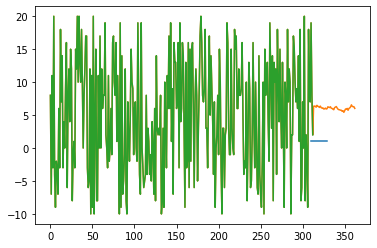

In [ ]:
plt.plot(test_x, y_ela)
plt.plot(win_x, win_y)
plt.plot(x, y)